# 例子：预测自行车流量

我们来看一个例子，试图从天气、季节和其他因素中对西雅图费利蒙大桥的自行车交通流量数据进行预测

本节中，我们会将自行车数据与另外一个数据集联合起来，然后从中找到哪些天气和季节因素，比方说温度、降雨和日照时间。幸运的是美国国家海洋和大气管理局NOAA公开了每天[气象站数据](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND)（作者使用的是气象站ID USW00024233的数据），我们可以使用Pandas很容易地联合两个数据集。然后我们使用简单的线性回归来拟合相关的天气以及其他因素和自行车数量，以此来估计给定一天的任何其中一个参数改变对骑行者数量的影响。

特别这是在统计模型框架中使用Scikit-Learn工具的例子，其中的模型参数被认为是有可解释的含义的。正如之前讨论的，这不是机器学习的标准方法，但是对于一些模型来说这样的解释是存在的。让我们首先载入两个数据集，使用日期进行索引：

In [7]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv',index_col='Date',parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv',index_col='DATE',parse_dates=True)

In [10]:
daily = counts.resample('d').sum()
daily=daily[['Fremont Bridge Total']].rename(columns={'Fremont Bridge Total':'Total'})

我们之前看到自行车流量随着星期天数而发生不同变化；因此让我们将这点也考虑进来，为这个数据集增加7个布尔值的列表示星期天数：

In [11]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
        daily[days[i]] = (daily.index.dayofweek == i).astype(float)

类似的，我们也期望骑手们在节日会有不同习惯；让我们将这点也考虑进来，加入一个标识列：

In [13]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2013-12-21,520.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2013-12-22,400.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-12-23,1417.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


我们同样猜测日照时间也会影响多少人骑自行车；我们使用标准天文计算来增加这个信息：

(8.0, 17.0)

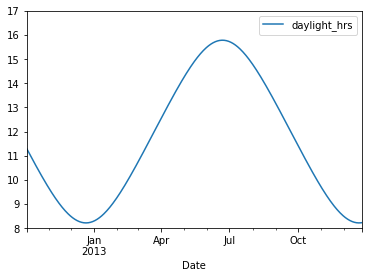

In [17]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """
    计算给定日期的日照时间
    axis 23.44 黄赤夹角
    latitude 47.61 西雅图纬度
    """
    # 2000年12月21日是冬至日，日照时间最短
    days = (date - datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

我们也可以增加平均气温和总降雨量数据。除了单位为英寸的降雨量列外，我们再增加一列标志表示当天是否干燥（降雨量为0）：

In [18]:
# 气温单位是0.1摄氏度，求平均值
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# 降雨量单位是0.1毫米，转换为英寸
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [19]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [20]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1,0.010959


In [21]:
# 移除所有有空值的行
from sklearn.linear_model import LinearRegression
daily.dropna(axis=0, how='any', inplace=True)

# 用来拟合模型的列包括星期几、日照小时数、降水量、是否有雨、气温、该天的年计数
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

最终我们将预测的自行车交通流量和实际总量进行比较绘制图表：

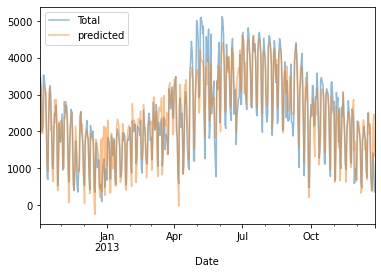

In [22]:
daily[['Total', 'predicted']].plot(alpha=0.5);

很明显我们遗失了一些关键的特征，特别是在夏天的时候。或者数据之间具有非线性的关系我们并未考虑进来（如人们在高温和低温的情况下都会减少骑行）。无论如何，我们这个粗糙的估计给了我们一些内在解释，我们可以查看这个线性模型的系数，从中得到每个特征是如何影响每天自行车总量的：

In [24]:
params = pd.Series(model.coef_,index=X.columns)
params

Mon              515.625076
Tue              569.208710
Wed              620.976116
Thu              516.732411
Fri              215.115645
Sat             -974.552013
Sun             -962.723682
holiday        -1107.248602
daylight_hrs     120.031111
PRCP            -694.740645
dry day          515.857529
Temp (C)          67.540829
annual            18.958073
dtype: float64

这些数字如果没有一种对它们不确定性的度量方式的话很难解读。我们可以使用对数据的重采样来快速的计算这些不确定性：

In [26]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [28]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            516.0  142.0
Tue            569.0  133.0
Wed            621.0  134.0
Thu            517.0  138.0
Fri            215.0  131.0
Sat           -975.0  130.0
Sun           -963.0  138.0
holiday      -1107.0  239.0
daylight_hrs   120.0   15.0
PRCP          -695.0   87.0
dry day        516.0   51.0
Temp (C)        68.0    5.0
annual          19.0   54.0


|首先看到的是每周相对稳定的变化趋势：显然工作日比周末的骑行者要多得多。如果每天日照时间多一个小时，就会多出240.0 ± 31.0个骑行者；气温升高一摄氏度会多出135.0 ± 10.0个骑行者；晴天意味着会多出1032.0 ± 103.0个骑行者；而每多一英寸降雨意味着会有1389.0 ± 175.0个人决定将自行车留在家。一旦所有因素都计算在内，我们发现每年同一天会平均多出38.0 ± 109.0个骑行者。